# Analyzing GRB 080916C
![Alt text](https://astrobites.org/wp-content/uploads/2014/10/NASAGRBwhoa-1024x576.jpg)
*(NASA/Swift/Cruz deWilde)*

To demonstrate the capabilities and features of 3ML in, we will go through a time-integrated and time-resolved analysis. This example serves as a standard way to analyze Fermi-GBM data with 3ML as well as a template for how you can design your instrument's analysis pipeline with 3ML if you have similar data.

3ML provides utilities to reduce time series data to plugins in a *correct* and *statistically justified* way (e.g., background fitting of Poisson data is done with a Poisson likelihood). The approach is generic and can be extended. For more details, see the [time series documentation](https://threeml.readthedocs.io/en/stable/notebooks/Building_Plugins_from_TimeSeries.html).

In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

np.seterr(all="ignore")


from threeML import *
from threeML.io.package_data import get_path_of_data_file

In [3]:

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

## Examining the catalog

As with Swift and Fermi-LAT, 3ML provides a simple interface to the on-line Fermi-GBM catalog. Let's get the information for GRB 080916C.

In [4]:
gbm_catalog = FermiGBMBurstCatalog()
gbm_catalog.query_sources("GRB080916009")

18:27:17 INFO      The cache for fermigbrst does not yet exist. We will try to    ]8;id=630942;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=940049;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#64\64]8;;\
                  build it                                                                                         
                                                                                                                   

         INFO      Building cache for fermigbrst                                 ]8;id=386897;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=369971;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#112\112]8;;\

<Table length=1>
    name        ra     dec    trigger_time   t90  
   object    float64 float64    float64    float64
------------ ------- ------- ------------- -------
GRB080916009 119.800 -56.600 54725.0088613  62.977

To aid in quickly replicating the catalog analysis, and thanks to the tireless efforts of the Fermi-GBM team, we have added the ability to extract the analysis parameters from the catalog as well as build an **astromodels** model with the best fit parameters baked in. Using this information, one can quickly run through the catalog an replicate the entire analysis with a script. Let's give it a try.

In [5]:
grb_info = gbm_catalog.get_detector_information()["GRB080916009"]

gbm_detectors = grb_info["detectors"]
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]
model = gbm_catalog.get_model(best_fit_model, "fluence")["GRB080916009"]

In [6]:
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (5):
--------------------

                                value min_value max_value            unit
GRB080916009...K             0.012255       0.0      None  keV-1 s-1 cm-2
GRB080916009...alpha        -1.130424      -1.5       2.0                
GRB080916009...break_energy  309.2031      10.0      None             keV
GRB080916009...break_scale        0.3       0.0      10.0                
GRB080916009...beta         -2.096931      -5.0      -1.6                

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

## Downloading the data
We provide a simple interface to download the Fermi-GBM data. Using the information from the catalog that we have extracted, we can download just the data from the detectors that were used for the catalog analysis. This will download the CSPEC, TTE and instrument response files from the on-line database.



In [7]:
dload = download_GBM_trigger_data("bn080916009", detectors=gbm_detectors)

Let's first examine the catalog fluence fit. Using the **TimeSeriesBuilder**, we can fit the background, set the source interval, and create a 3ML plugin for the analysis. We will loop through the detectors, set their appropriate channel selections, and ensure there are enough counts in each bin to make the [PGStat profile likelihood valid](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/).

* First we use the CSPEC data to fit the background using the background selections. We use CSPEC because it has a longer duration for fitting the background.
* The background is saved to an HDF5 file that stores the polynomial coefficients and selections which we can read in to the TTE file later.
* The light curve is plotted.
* The source selection from the catalog is set and **DispersionSpectrumLike** plugin is created.
* The plugin has the standard GBM channel selections for spectral analysis set.

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/4 [00:00<?, ?it/s]

18:28:17 INFO      Auto-determined polynomial order: 0                                ]8;id=275551;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=878825;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_03 background:   0%|          | 0/128 [00:00<?, ?it/s]

18:28:26 INFO      None 0-order polynomial fit with the mle method                               ]8;id=560948;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=535154;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=38821;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=996872;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=410054;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=756891;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

18:28:27 INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=352802;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=768685;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=121084;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=344713;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=810640;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=316699;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#490\490]8;;\

         INFO      - observation: poisson                                                       ]8;id=29360;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=46655;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#491\491]8;;\

         INFO      - background: gaussian                                                       ]8;id=261040;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=513441;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#492\492]8;;\

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=668247;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=515707;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

18:28:30 INFO      Now using 120 bins                                                          ]8;id=779195;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=493700;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/4 [00:00<?, ?it/s]

18:28:32 INFO      Auto-determined polynomial order: 1                                ]8;id=983442;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=931680;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_04 background:   0%|          | 0/128 [00:00<?, ?it/s]

18:28:46 INFO      None 1-order polynomial fit with the mle method                               ]8;id=149835;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=354773;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n4_bkg.h5                                         ]8;id=977733;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=350857;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n4_bkg.h5                                         ]8;id=408490;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=523099;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n4_bkg.h5                              ]8;id=388624;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=118565;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=460389;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=388749;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=468059;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=280922;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#490\490]8;;\

         INFO      - observation: poisson                                                       ]8;id=299591;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=430050;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#491\491]8;;\

         INFO      - background: gaussian                                                       ]8;id=984511;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=967583;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#492\492]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=492826;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=316036;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=367508;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=62965;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/4 [00:00<?, ?it/s]

18:28:49 INFO      Auto-determined polynomial order: 1                                ]8;id=131610;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=256455;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_BGO_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

18:29:02 INFO      None 1-order polynomial fit with the mle method                               ]8;id=798592;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=319655;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=457898;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=4966;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=799269;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=786448;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

18:29:03 INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=78379;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=825346;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=757620;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=574256;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=740063;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=978467;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#490\490]8;;\

         INFO      - observation: poisson                                                       ]8;id=874330;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=625513;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#491\491]8;;\

         INFO      - background: gaussian                                                       ]8;id=576825;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=70317;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#492\492]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=586424;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=703100;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=134404;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=397710;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

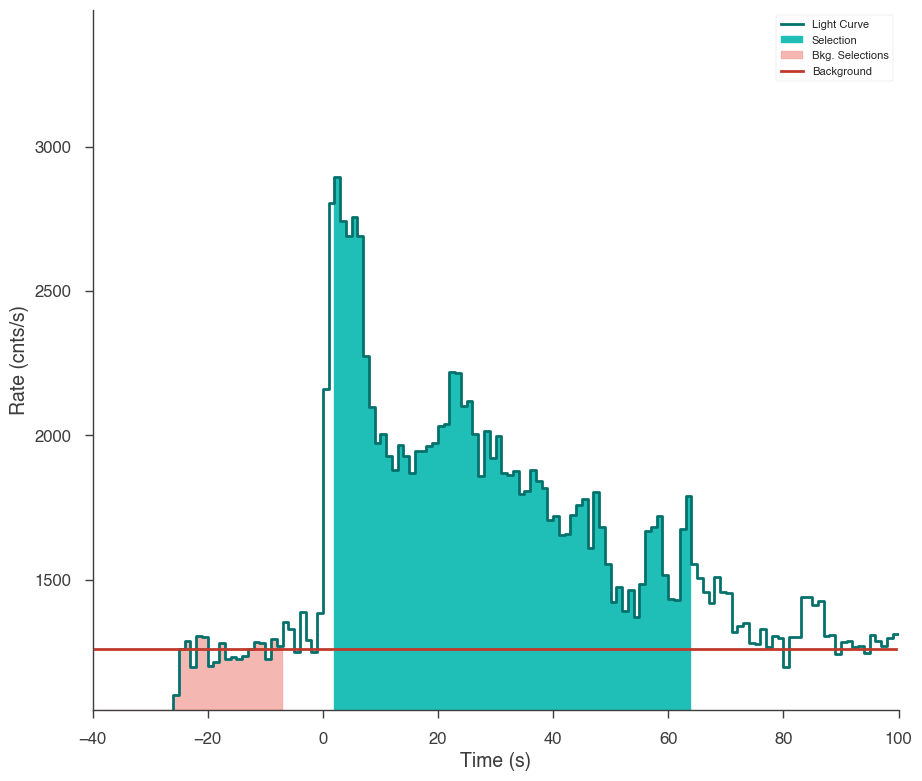

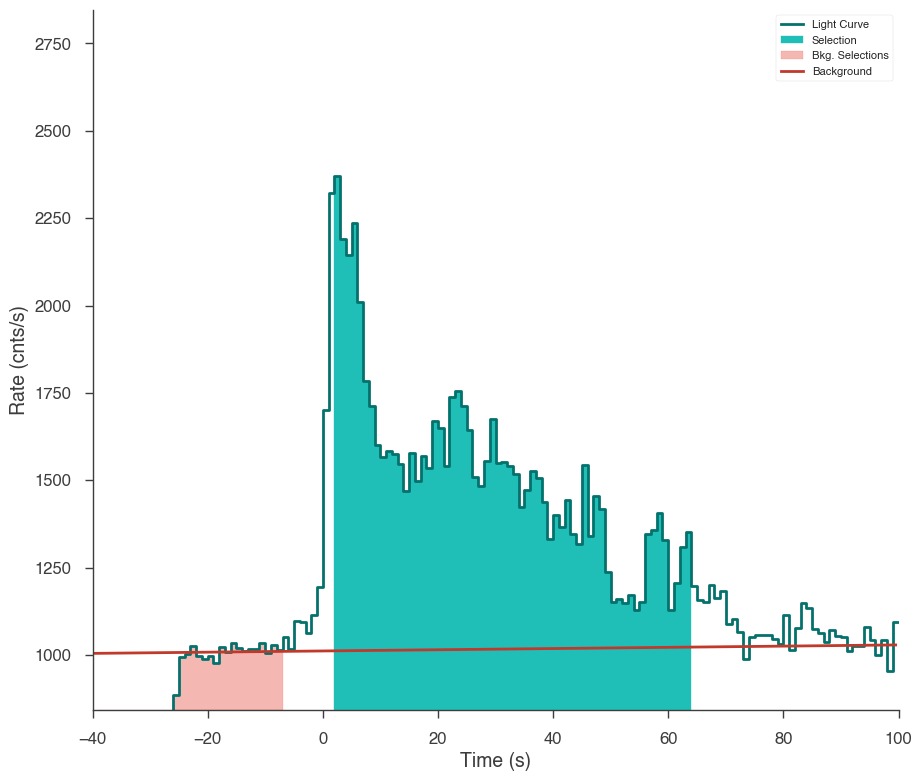

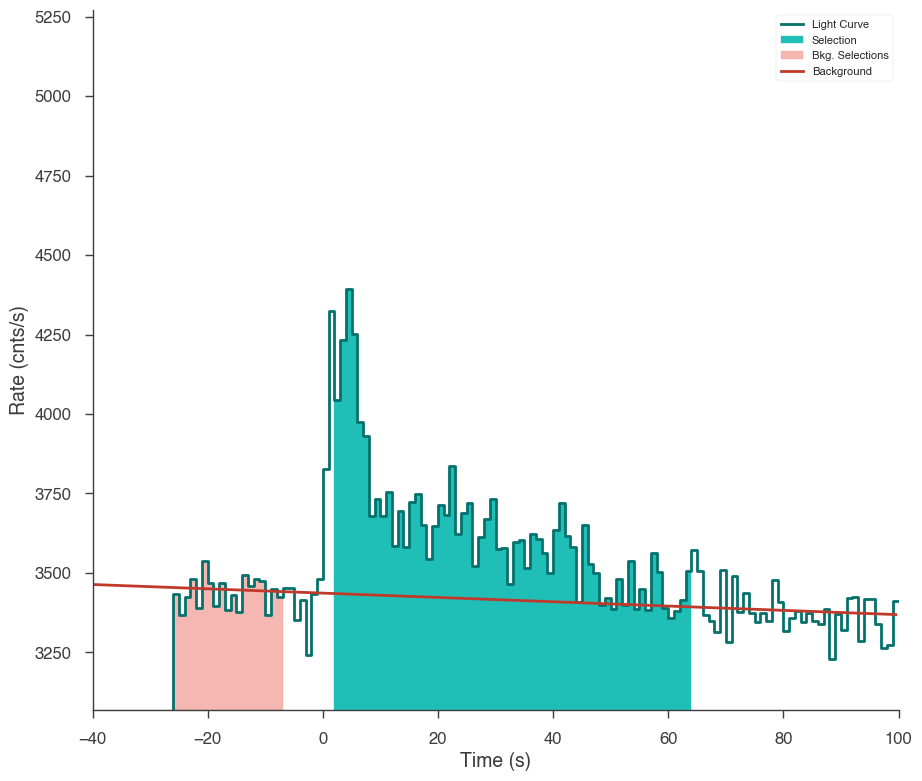

In [8]:
fluence_plugins = []
time_series = {}
for det in gbm_detectors:
    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )

    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    ts_tte.view_lightcurve(-40, 100)

    fluence_plugin = ts_tte.to_spectrumlike()

    if det.startswith("b"):
        fluence_plugin.set_active_measurements("250-30000")

    else:
        fluence_plugin.set_active_measurements("9-900")

    fluence_plugin.rebin_on_background(1.0)

    fluence_plugins.append(fluence_plugin)

## Setting up the fit
Let's see if we can reproduce the results from the catalog.

### Set priors for the model
We will fit the spectrum using Bayesian analysis, so we must set priors on the model parameters.


In [9]:
model.GRB080916009.spectrum.main.shape.alpha.prior = Truncated_gaussian(
    lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.beta.prior = Truncated_gaussian(
    lower_bound=-5, upper_bound=-1.6, mu=-2.25, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.break_energy.prior = Log_normal(mu=2, sigma=1)
model.GRB080916009.spectrum.main.shape.break_energy.bounds = (None, None)
model.GRB080916009.spectrum.main.shape.K.prior = Log_uniform_prior(
    lower_bound=1e-3, upper_bound=1e1
)
model.GRB080916009.spectrum.main.shape.break_scale.prior = Log_uniform_prior(
    lower_bound=1e-4, upper_bound=10
)

### Clone the model and setup the Bayesian analysis class
Next, we clone the model we built from the catalog so that we can look at the results later and fit the cloned model. We pass this model and the **DataList** of the plugins to a **BayesianAnalysis** class and set the sampler to MultiNest.

In [10]:
new_model = clone_model(model)

bayes = BayesianAnalysis(new_model, DataList(*fluence_plugins))

# share spectrum gives a linear speed up when
# spectrumlike plugins have the same RSP input energies
bayes.set_sampler("multinest", share_spectrum=True)

18:29:04 INFO      sampler set to multinest                                                ]8;id=607883;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=559023;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

### Examine at the catalog fitted model
We can quickly examine how well the catalog fit matches the data. There appears to be a discrepancy between the data and the model! Let's refit to see if we can fix it.

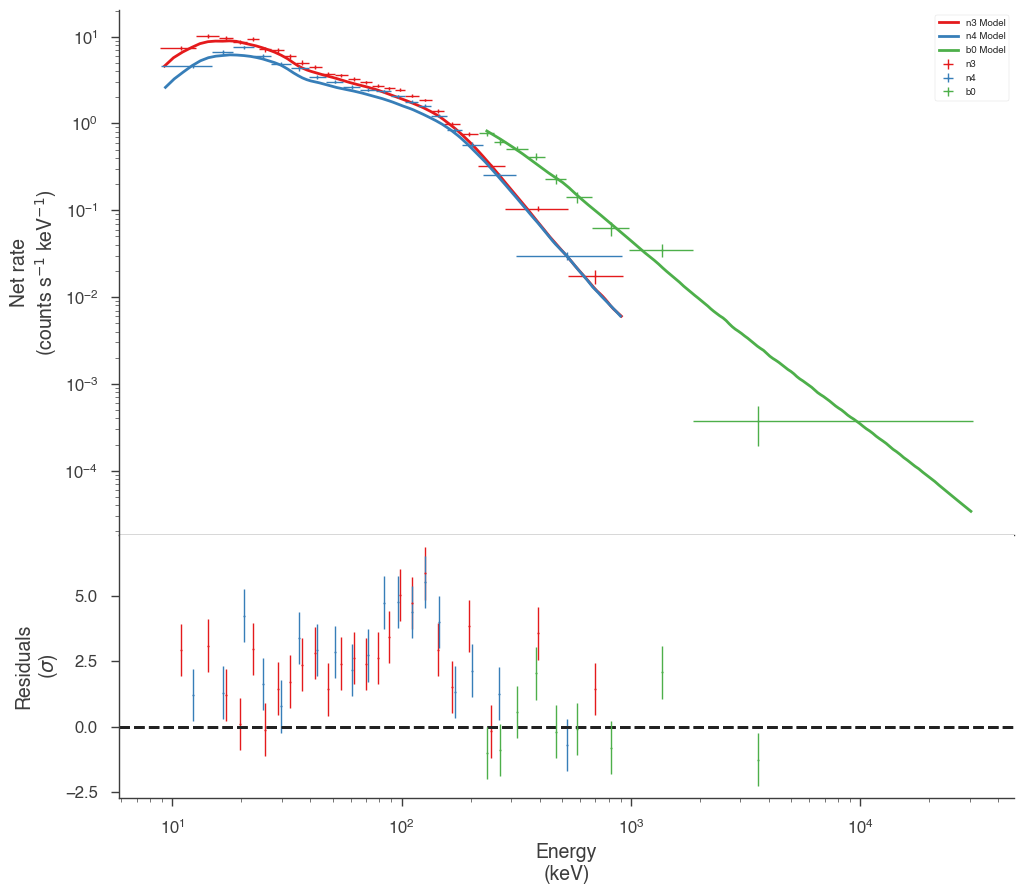

In [11]:
fig = display_spectrum_model_counts(bayes, min_rate=20, step=False)

### Run the sampler
We let MultiNest condition the model on the data

In [12]:
bayes.sampler.setup(n_live_points=400)
bayes.sample()

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -3101.1815714369950      +/-  0.22451188311220827     
 Total Likelihood Evaluations:        23342
 Sampling finished. Exiting MultiNest



18:29:19 INFO      fit restored to maximum of posterior                                         ]8;id=180961;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=957432;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=609921;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=395311;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                  
GRB080916009...K             (1.470 -0.020 +0.018) x 10^-2  1 / (cm2 keV s)
GRB080916009...alpha                   -1.101 +0.007 +0.05                 
GRB080916009...break_energy       (1.89 +0.13 +0.7) x 10^2              keV
GRB080916009...break_scale         (0.0 +1.7 +3.4) x 10^-1                 
GRB080916009...beta                      -1.97 -0.21 -0.04

Values of -log(posterior) at the minimum:

-log(posterior)
b0        -1049.484738
n3        -1019.875618
n4        -1009.886554
total     -3079.246910

Values of statistical measures:

statistical measures
AIC              6168.664275
BIC              6187.896486
DIC              6179.580233
PDIC                4.230147
log(Z)          -1346.826044

Now our model seems to match much better with the data!

         INFO      fit restored to median of posterior                                          ]8;id=200157;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=518468;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

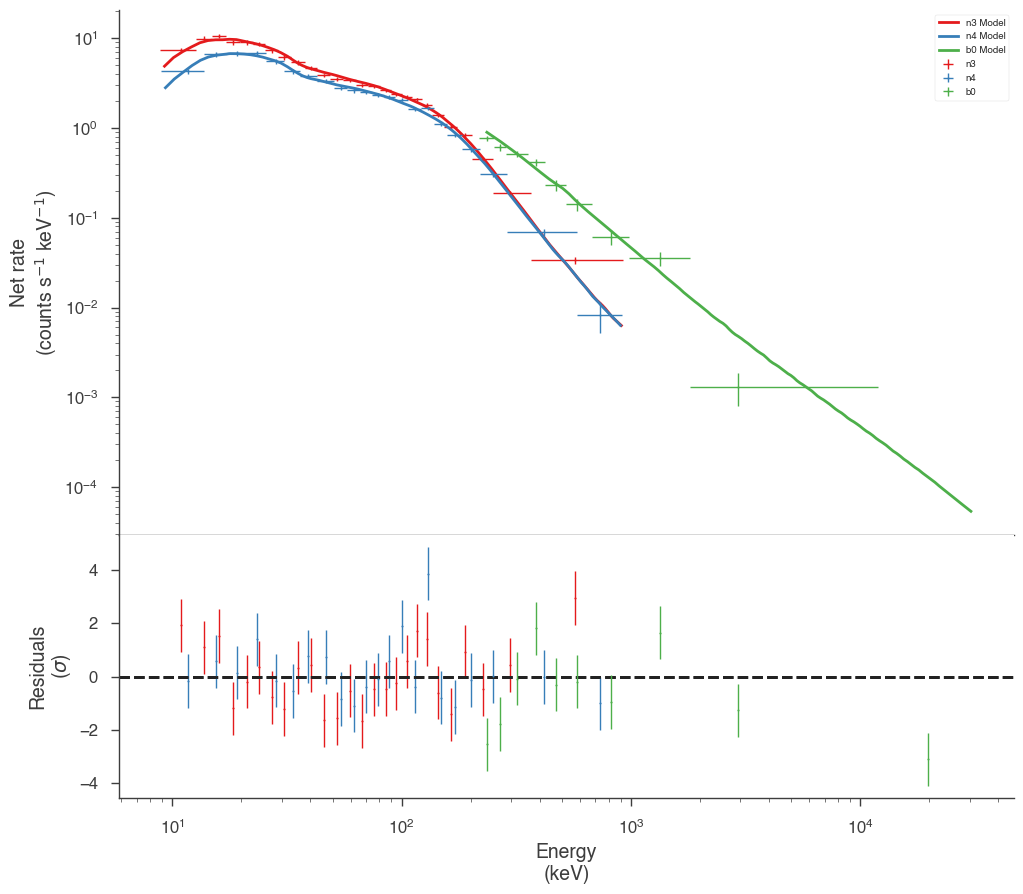

In [13]:
bayes.restore_median_fit()
fig = display_spectrum_model_counts(bayes, min_rate=20)

But how different are we from the catalog model? Let's plot our fit along with the catalog model. Luckily, 3ML can handle all the units for is

In [14]:
conversion = u.Unit("keV2/(cm2 s keV)").to("erg2/(cm2 s keV)")
energy_grid = np.logspace(1, 4, 100) * u.keV
vFv = (energy_grid**2 * model.get_point_source_fluxes(0, energy_grid)).to(
    "erg2/(cm2 s keV)"
)

processing Bayesian analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

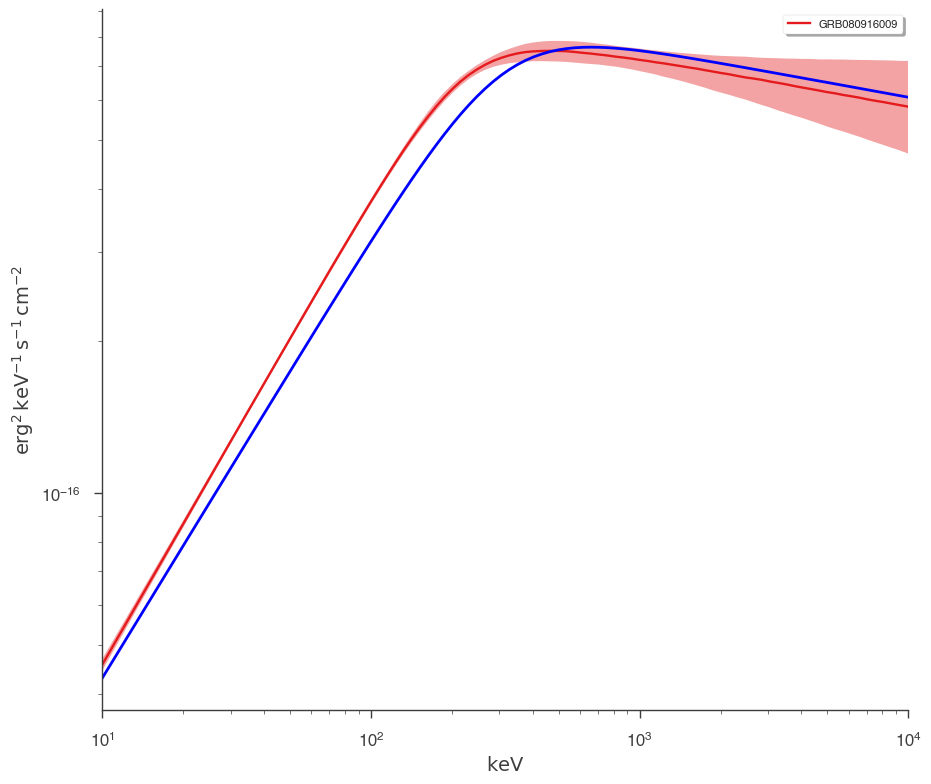

In [15]:
fig = plot_spectra(bayes.results, flux_unit="erg2/(cm2 s keV)")
ax = fig.get_axes()[0]
_ = ax.loglog(energy_grid, vFv, color="blue", label="catalog model")

## Time Resolved Analysis

Now that we have examined fluence fit, we can move to performing a time-resolved analysis.

### Selecting a temporal binning

We first get the brightest NaI detector and create time bins via the Bayesian blocks algorithm. We can use the fitted background to make sure that our intervals are chosen in an unbiased way.

In [16]:
n3 = time_series["n3"]

In [17]:
n3.create_time_bins(0, 60, method="bayesblocks", use_background=True, p0=0.2)

18:31:09 INFO      Created 15 bins via bayesblocks                                       ]8;id=435786;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=146500;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Sometimes, glitches in the GBM data cause spikes in the data that the Bayesian blocks algorithm detects as fast changes in the count rate. We will have to remove those intervals manually.

<div class="alert alert-info">

**Note:** In the future, 3ML will provide an automated method to remove these unwanted spikes.

</div>


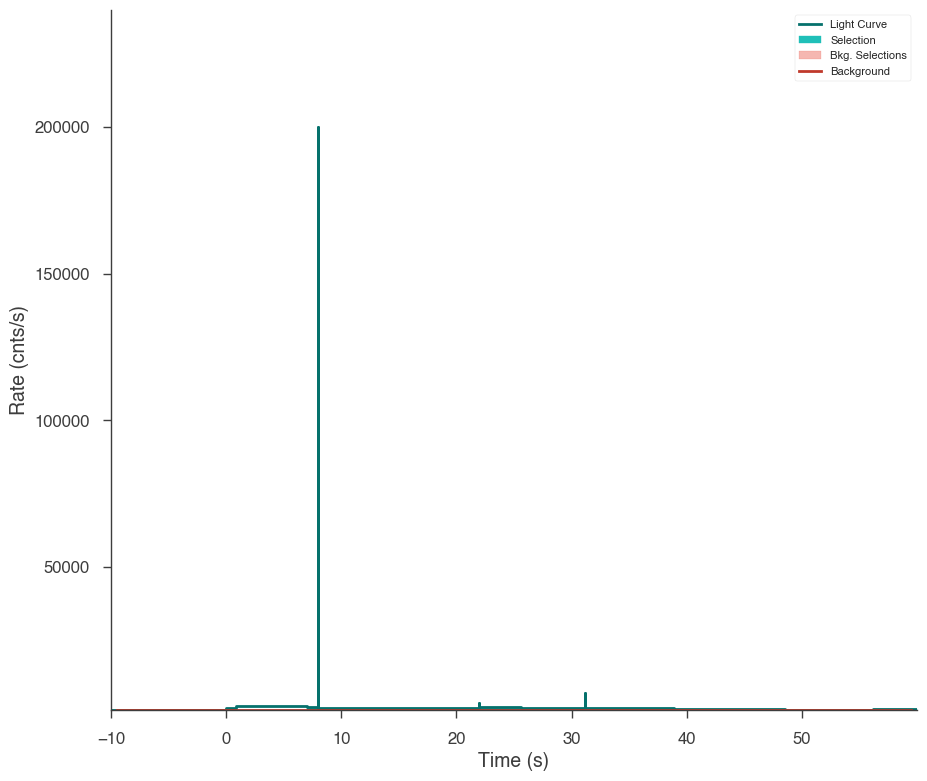

In [18]:
fig = n3.view_lightcurve(use_binner=True)

In [19]:
bad_bins = []
for i, w in enumerate(n3.bins.widths):
    if w < 5e-2:
        bad_bins.append(i)


edges = [n3.bins.starts[0]]

for i, b in enumerate(n3.bins):
    if i not in bad_bins:
        edges.append(b.stop)

starts = edges[:-1]
stops = edges[1:]


n3.create_time_bins(starts, stops, method="custom")

         INFO      Created 12 bins via custom                                            ]8;id=870990;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=951979;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Now our light curve looks much more acceptable.

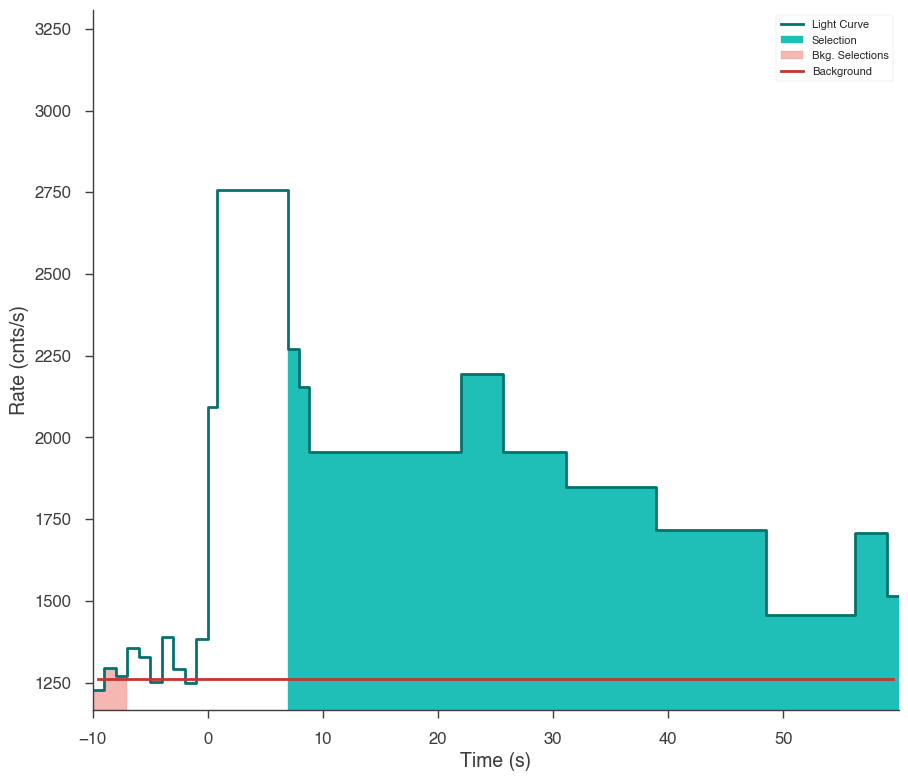

In [20]:
fig = n3.view_lightcurve(use_binner=True)

The time series objects can read time bins from each other, so we will map these time bins onto the other detectors' time series and create a list of time plugins for each detector and each time bin created above.

In [21]:
time_resolved_plugins = {}

for k, v in time_series.items():
    v.read_bins(n3)
    time_resolved_plugins[k] = v.to_spectrumlike(from_bins=True)

18:31:10 INFO      Created 12 bins via custom                                            ]8;id=741560;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=571964;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

         INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=852397;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=706642;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=101550;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=20663;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

18:31:11 INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=503820;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=465947;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=611109;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=24698;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

         INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=801380;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=386652;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

### Setting up the model
For the time-resolved analysis, we will fit the classic *Band* function to the data. We will set some principled priors.

In [22]:
band = Band()
band.alpha.prior = Truncated_gaussian(lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5)
band.beta.prior = Truncated_gaussian(lower_bound=-5, upper_bound=-1.6, mu=-2, sigma=0.5)
band.xp.prior = Log_normal(mu=2, sigma=1)
band.xp.bounds = (None, None)
band.K.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=1e3)
ps = PointSource("grb", 0, 0, spectral_shape=band)
band_model = Model(ps)

### Perform the fits

One way to perform Bayesian spectral fits to all the intervals is to loop through each one. There can are many ways to do this, so find an analysis pattern that works for you.



In [23]:
models = []
results = []
analysis = []
for interval in range(12):
    # clone the model above so that we have a separate model
    # for each fit

    this_model = clone_model(band_model)

    # for each detector set up the plugin
    # for this time interval

    this_data_list = []
    for k, v in time_resolved_plugins.items():
        pi = v[interval]

        if k.startswith("b"):
            pi.set_active_measurements("250-30000")
        else:
            pi.set_active_measurements("9-900")

        pi.rebin_on_background(1.0)

        this_data_list.append(pi)

    # create a data list

    dlist = DataList(*this_data_list)

    # set up the sampler and fit

    bayes = BayesianAnalysis(this_model, dlist)

    # get some speed with share spectrum
    bayes.set_sampler("multinest", share_spectrum=True)
    bayes.sampler.setup(n_live_points=500)
    bayes.sample()

    # at this stage we coudl also
    # save the analysis result to
    # disk but we will simply hold
    # onto them in memory

    analysis.append(bayes)

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=166122;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=289540;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

18:31:12 INFO      Now using 120 bins                                                          ]8;id=86466;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=353459;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=906776;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=675256;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=960264;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=519884;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=603674;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=524943;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 107 bins                                                          ]8;id=233422;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=4655;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=357368;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=68462;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -798.29555087660117      +/-  0.20044967195006688     
 Total Likelihood Evaluations:        17077
 Sampling finished. Exiting MultiNest



18:31:24 INFO      fit restored to maximum of posterior                                         ]8;id=731876;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=274097;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=609172;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=896387;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K       (3.94 +0.16 +1.4) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-5.75 -0.08 +1.5) x 10^-1                 
grb.spectrum.main.Band.xp       (2.54 -0.8 -0.09) x 10^2              keV
grb.spectrum.main.Band.beta          -1.730 -0.020 +0.05

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval0      -287.620175
n3_interval0      -250.365285
n4_interval0      -267.496239
total             -805.481699

Values of statistical measures:

statistical measures
AIC              1619.076712
BIC              1634.485529
DIC              1568.987918
PDIC               -6.908927
log(Z)           -346.695353

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=124084;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=838438;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=981958;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=36377;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=324235;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=772470;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=478215;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=954504;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=59245;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=365201;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=576735;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=416236;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=531819;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=668144;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1955.1611788336586      +/-  0.22154761409587490     
 Total Likelihood Evaluations:        23879
 Sampling finished. Exiting MultiNest



18:31:39 INFO      fit restored to maximum of posterior                                         ]8;id=945553;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=571864;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=184677;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=841388;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                 
grb.spectrum.main.Band.K       (4.58 -0.05 +0.15) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-7.96 -0.04 +0.35) x 10^-1                 
grb.spectrum.main.Band.xp      (4.757 -0.4 -0.017) x 10^2              keV
grb.spectrum.main.Band.beta           -1.899 +0.007 +0.04

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval1      -680.630055
n3_interval1      -642.314053
n4_interval1      -643.181391
total            -1966.125499

Values of statistical measures:

statistical measures
AIC              3940.364313
BIC              3955.773131
DIC              3888.785232
PDIC                2.282629
log(Z)           -849.115711

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=545042;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=654876;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=149241;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=923307;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=463135;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=633254;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=518239;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=208932;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=72882;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=68628;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 115 bins                                                          ]8;id=558179;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=252726;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=743676;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=664340;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -906.98297144222317      +/-  0.19918355563115239     
 Total Likelihood Evaluations:        20169
 Sampling finished. Exiting MultiNest



18:31:51 INFO      fit restored to maximum of posterior                                         ]8;id=824432;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=71381;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=983141;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=156452;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.47 -0.18 +0.19) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha           -1.07 -0.05 +0.06                 
grb.spectrum.main.Band.xp         (6.6 -1.2 +2.6) x 10^2              keV
grb.spectrum.main.Band.beta             -2.07 -0.5 -0.06

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval2      -325.084737
n3_interval2      -289.560256
n4_interval2      -312.971178
total             -927.616171

Values of statistical measures:

statistical measures
AIC              1863.345656
BIC              1878.754474
DIC              1805.623728
PDIC                2.045628
log(Z)           -393.897700

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=743111;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=886573;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=436682;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=325462;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=6622;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=659850;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=594635;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=538964;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=447289;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=854856;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 109 bins                                                          ]8;id=501953;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=71527;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=300995;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=632311;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -789.55896640591800      +/-  0.18039927414433127     
 Total Likelihood Evaluations:        17406
 Sampling finished. Exiting MultiNest



18:32:02 INFO      fit restored to maximum of posterior                                         ]8;id=957595;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=883827;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=904661;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=124591;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                               
grb.spectrum.main.Band.K      (2.88 -0.13 +0.6) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha   (-9.2 -0.4 +1.2) x 10^-1                 
grb.spectrum.main.Band.xp      (3.45 -0.9 +0.32) x 10^2              keV
grb.spectrum.main.Band.beta           -2.24 +0.05 +0.34

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval3      -298.424363
n3_interval3      -242.521820
n4_interval3      -262.648946
total             -803.595129

Values of statistical measures:

statistical measures
AIC              1615.303573
BIC              1630.712390
DIC              1569.549069
PDIC                2.280395
log(Z)           -342.901102

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=457288;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=219564;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=398679;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=776843;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=945811;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=538824;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=363124;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=631912;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=151123;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=990602;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=163864;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=817013;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=499625;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=104299;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2277.7754225455324      +/-  0.21456724636098054     
 Total Likelihood Evaluations:        21397
 Sampling finished. Exiting MultiNest



18:32:17 INFO      fit restored to maximum of posterior                                         ]8;id=379786;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=439874;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=418934;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=48956;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                  
grb.spectrum.main.Band.K      (2.221 +0.024 +0.17) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha    (-9.17 +0.12 +0.4) x 10^-1                 
grb.spectrum.main.Band.xp         (3.58 -0.4 -0.07) x 10^2              keV
grb.spectrum.main.Band.beta          -2.0725 -0.0008 +0.05

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval4      -779.066984
n3_interval4      -759.511895
n4_interval4      -745.592853
total            -2284.171732

Values of statistical measures:

statistical measures
AIC              4576.456778
BIC              4591.865595
DIC              4531.489614
PDIC                1.462624
log(Z)           -989.225297

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=807379;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=779239;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=481748;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=62356;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=84675;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=580081;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=119886;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=265143;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=429962;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=268242;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=91893;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=425958;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=785320;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=221002;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1573.0018489753970      +/-  0.19128717316060656     
 Total Likelihood Evaluations:        19841
 Sampling finished. Exiting MultiNest



18:32:29 INFO      fit restored to maximum of posterior                                         ]8;id=591242;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=988521;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=778741;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=220946;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.77 -0.18 +0.19) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha      (-9.2 +/- 0.5) x 10^-1                 
grb.spectrum.main.Band.xp         (4.3 -0.5 +0.7) x 10^2              keV
grb.spectrum.main.Band.beta            -2.13 -0.27 +0.09

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval5      -536.973601
n3_interval5      -523.424054
n4_interval5      -527.802826
total            -1588.200481

Values of statistical measures:

statistical measures
AIC              3184.514276
BIC              3199.923093
DIC              3136.622932
PDIC                3.278837
log(Z)           -683.146023

18:32:30 INFO      Range 9-900 translates to channels 5-124                                    ]8;id=547013;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=956732;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=906144;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=285792;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=311370;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=620767;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=340718;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=643186;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=336115;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=55036;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=709388;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=935168;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=543922;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=819920;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1754.7784033182991      +/-  0.19022838832320757     
 Total Likelihood Evaluations:        20483
 Sampling finished. Exiting MultiNest



18:32:41 INFO      fit restored to maximum of posterior                                         ]8;id=151401;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=949278;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=293391;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=784607;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (1.95 -0.12 +0.13) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha              -1.02 +/- 0.05                 
grb.spectrum.main.Band.xp         (4.5 -0.5 +0.8) x 10^2              keV
grb.spectrum.main.Band.beta             -2.38 -0.4 +0.20

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval6      -609.551716
n3_interval6      -584.378753
n4_interval6      -576.910474
total            -1770.840943

Values of statistical measures:

statistical measures
AIC              3549.795201
BIC              3565.204018
DIC              3501.487742
PDIC                3.472375
log(Z)           -762.090578

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=834120;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=391468;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=139907;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=546664;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=834973;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=636408;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=959641;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=946401;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=462467;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=313980;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=113819;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=945230;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=99550;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=325813;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1939.4087966628908      +/-  0.19192557927356738     
 Total Likelihood Evaluations:        19390
 Sampling finished. Exiting MultiNest



18:32:53 INFO      fit restored to maximum of posterior                                         ]8;id=201860;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=27935;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=458957;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=584845;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (1.69 -0.10 +0.09) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha           -1.03 -0.05 +0.04                 
grb.spectrum.main.Band.xp         (4.2 -0.4 +0.8) x 10^2              keV
grb.spectrum.main.Band.beta             -2.20 -0.4 +0.09

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval7      -662.239555
n3_interval7      -640.755782
n4_interval7      -650.252553
total            -1953.247890

Values of statistical measures:

statistical measures
AIC              3914.609094
BIC              3930.017912
DIC              3868.579115
PDIC                3.284519
log(Z)           -842.274539

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=359089;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=368437;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=179849;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=322773;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=737761;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=387833;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=439070;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=918084;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=120908;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=489584;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=626903;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=376345;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=776643;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=5478;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2054.2333786286999      +/-  0.18870230498374302     
 Total Likelihood Evaluations:        19698
 Sampling finished. Exiting MultiNest



18:33:05 INFO      fit restored to maximum of posterior                                         ]8;id=797045;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=931381;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=108276;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=363261;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (1.53 -0.12 +0.15) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha    (-8.5 -0.6 +0.7) x 10^-1                 
grb.spectrum.main.Band.xp         (3.7 -0.5 +0.6) x 10^2              keV
grb.spectrum.main.Band.beta             -2.25 -0.4 +0.11

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval8      -702.130149
n3_interval8      -698.306458
n4_interval8      -666.220813
total            -2066.657420

Values of statistical measures:

statistical measures
AIC              4141.428154
BIC              4156.836972
DIC              4097.887628
PDIC                3.258087
log(Z)           -892.142221

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=541491;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=668108;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=266388;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=531745;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=307261;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=26973;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=116192;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=697918;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=235749;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=249033;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=227133;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=336679;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=872210;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=21135;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1878.4761492548209      +/-  0.14379233015635132     
 Total Likelihood Evaluations:        13146
 Sampling finished. Exiting MultiNest



18:33:12 INFO      fit restored to maximum of posterior                                         ]8;id=9975;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=790599;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=323931;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=849089;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                              
grb.spectrum.main.Band.K       (1.1 -0.4 +1.1) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-8.7 -1.8 +3.1) x 10^-1                 
grb.spectrum.main.Band.xp     (1.09 -0.35 +0.6) x 10^2              keV
grb.spectrum.main.Band.beta          -1.86 -0.34 +0.12

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval9      -648.227996
n3_interval9      -616.933514
n4_interval9      -616.242789
total            -1881.404299

Values of statistical measures:

statistical measures
AIC              3770.921912
BIC              3786.330730
DIC              3708.004822
PDIC              -39.093363
log(Z)           -815.811826

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=19611;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=32715;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=261548;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=561940;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=659329;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=277240;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=334390;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=851339;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=978911;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=460253;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=876108;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=906651;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=129306;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=792588;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1321.8603457225206      +/-  0.16573941052005259     
 Total Likelihood Evaluations:        15820
 Sampling finished. Exiting MultiNest



18:33:22 INFO      fit restored to maximum of posterior                                         ]8;id=772996;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=815595;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=941309;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=5311;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                              
grb.spectrum.main.Band.K       (2.0 -0.4 +0.5) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-7.5 -1.4 +1.3) x 10^-1                 
grb.spectrum.main.Band.xp       (2.2 -0.4 +0.7) x 10^2              keV
grb.spectrum.main.Band.beta           -1.95 -0.4 +0.10

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval10      -460.873861
n3_interval10      -437.605877
n4_interval10      -433.305854
total             -1331.785591

Values of statistical measures:

statistical measures
AIC              2671.684497
BIC              2687.093314
DIC              2634.463005
PDIC                0.754472
log(Z)           -574.076654

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=807959;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=452857;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 120 bins                                                          ]8;id=782614;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=278724;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=71171;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=773466;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=893741;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=338345;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=505782;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=882694;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1247\1247]8;;\

         INFO      Now using 119 bins                                                          ]8;id=164421;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=382876;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1739\1739]8;;\

         INFO      sampler set to multinest                                                ]8;id=630572;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=218595;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#202\202]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -812.33480621563581      +/-  0.15043167123748710     
 Total Likelihood Evaluations:        11858
 Sampling finished. Exiting MultiNest



18:33:30 INFO      fit restored to maximum of posterior                                         ]8;id=49641;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=287716;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=660886;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=533612;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                               
grb.spectrum.main.Band.K        (2.6 -0.6 +1.2) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha   (-5.2 -1.5 +2.2) x 10^-1                 
grb.spectrum.main.Band.xp     (1.31 -0.23 +0.27) x 10^2              keV
grb.spectrum.main.Band.beta            -2.13 -0.4 +0.18

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval11      -292.316518
n3_interval11      -272.248504
n4_interval11      -255.922670
total              -820.487692

Values of statistical measures:

statistical measures
AIC              1649.088698
BIC              1664.497516
DIC              1618.964716
PDIC                2.227909
log(Z)           -352.792524

### Examine the fits
Now we can look at the fits in count space to make sure they are ok.

         INFO      fit restored to median of posterior                                          ]8;id=217523;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=941828;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=625120;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=29093;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

18:33:31 INFO      fit restored to median of posterior                                          ]8;id=568368;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=760046;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

18:33:32 INFO      fit restored to median of posterior                                          ]8;id=717872;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=97556;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

18:33:33 INFO      fit restored to median of posterior                                          ]8;id=230493;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=71048;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=282948;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=752515;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

18:33:34 INFO      fit restored to median of posterior                                          ]8;id=784204;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=201890;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

18:33:35 INFO      fit restored to median of posterior                                          ]8;id=576381;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=343508;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=133785;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=741435;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

18:33:36 INFO      fit restored to median of posterior                                          ]8;id=348274;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=406096;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

18:33:37 INFO      fit restored to median of posterior                                          ]8;id=233215;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=447027;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=825676;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=672371;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

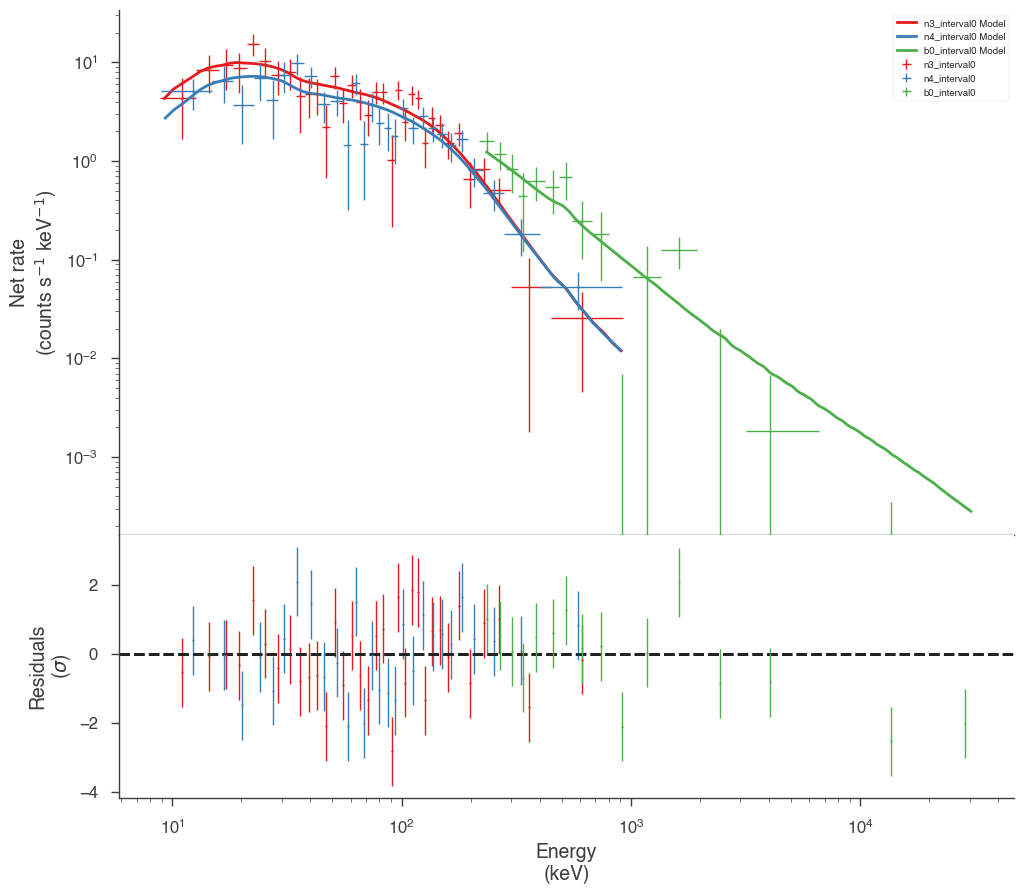

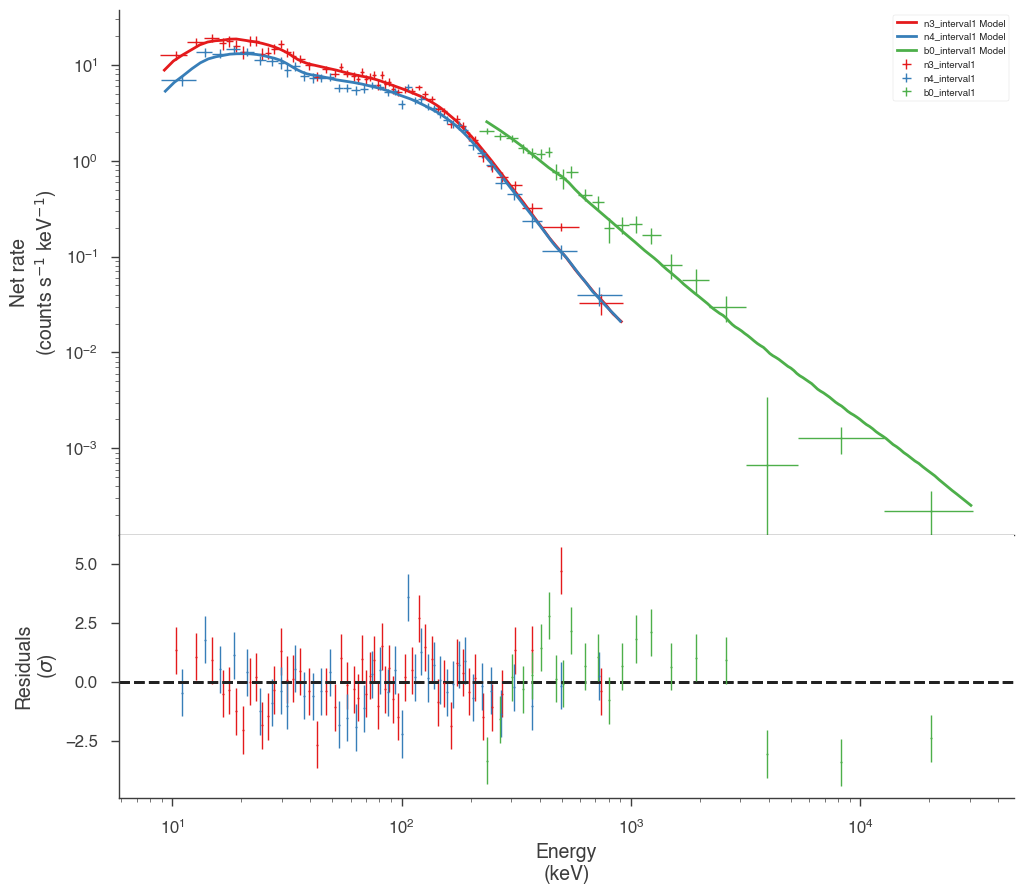

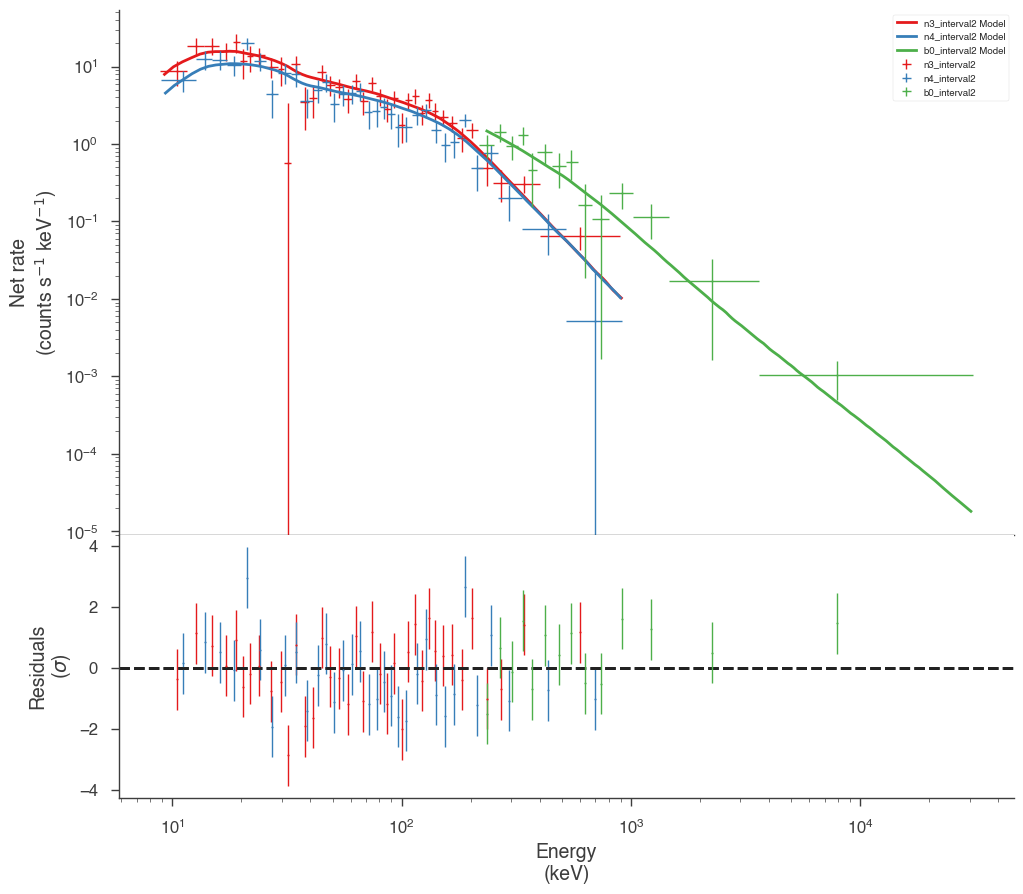

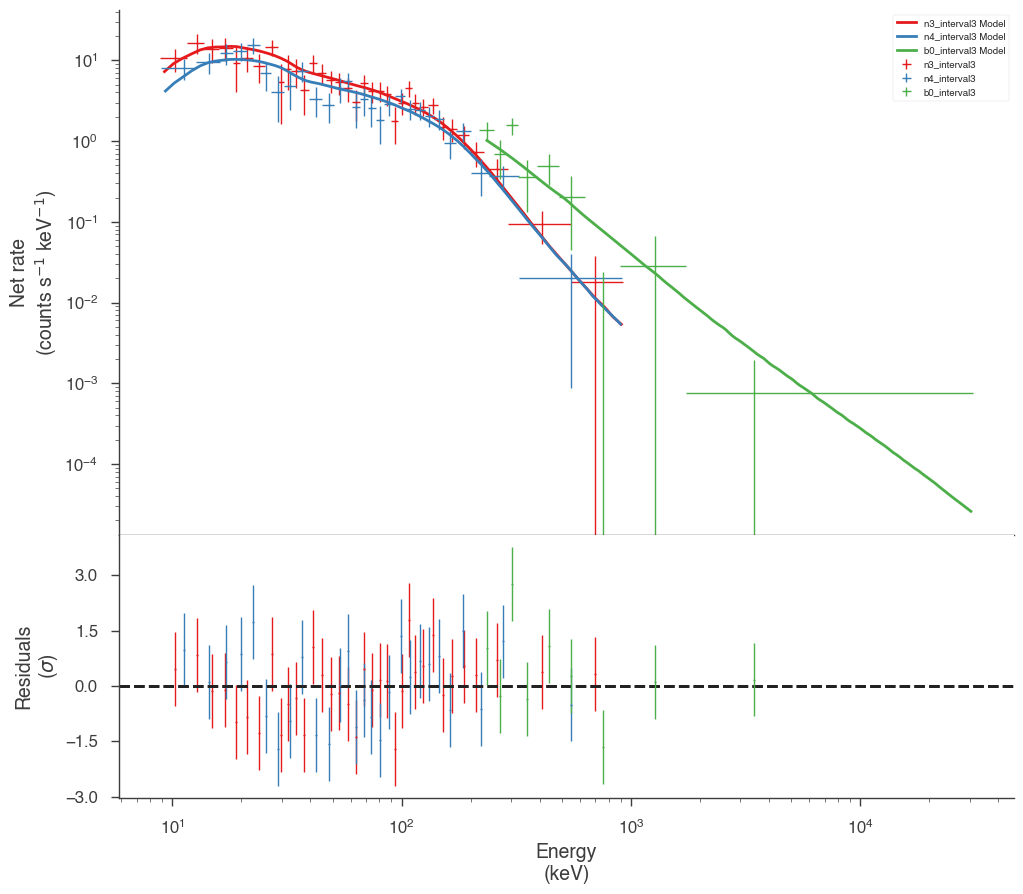

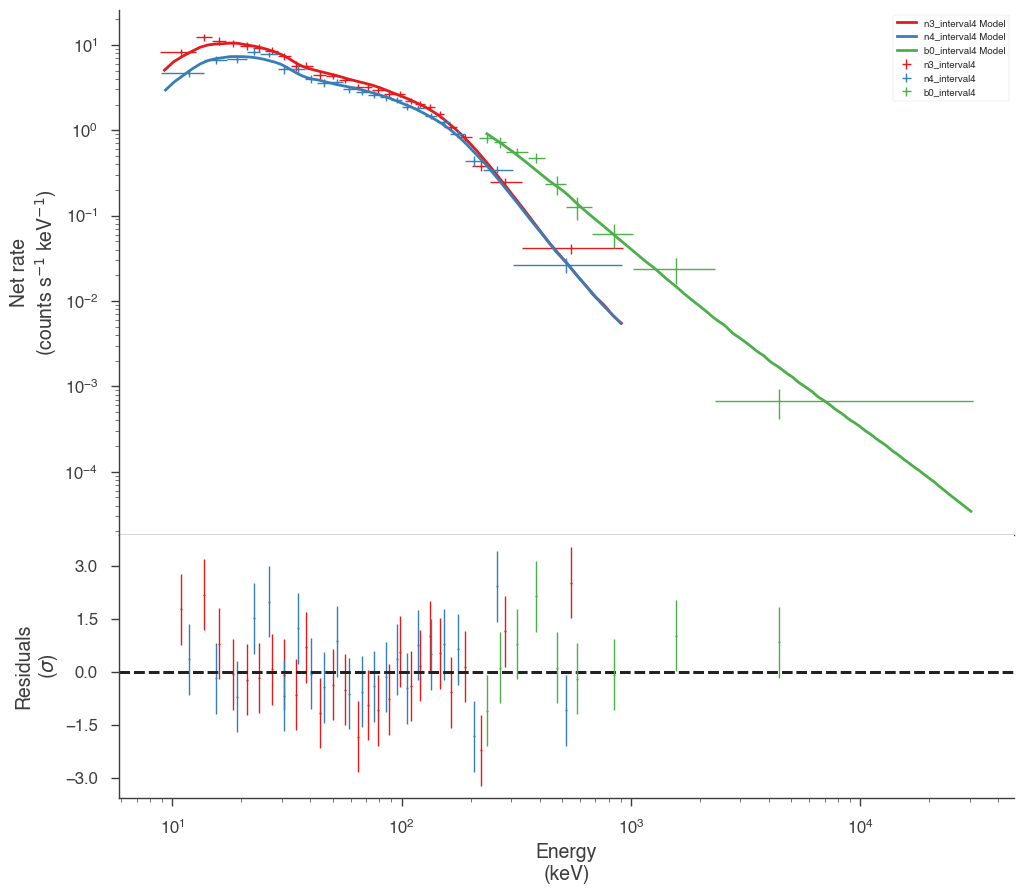

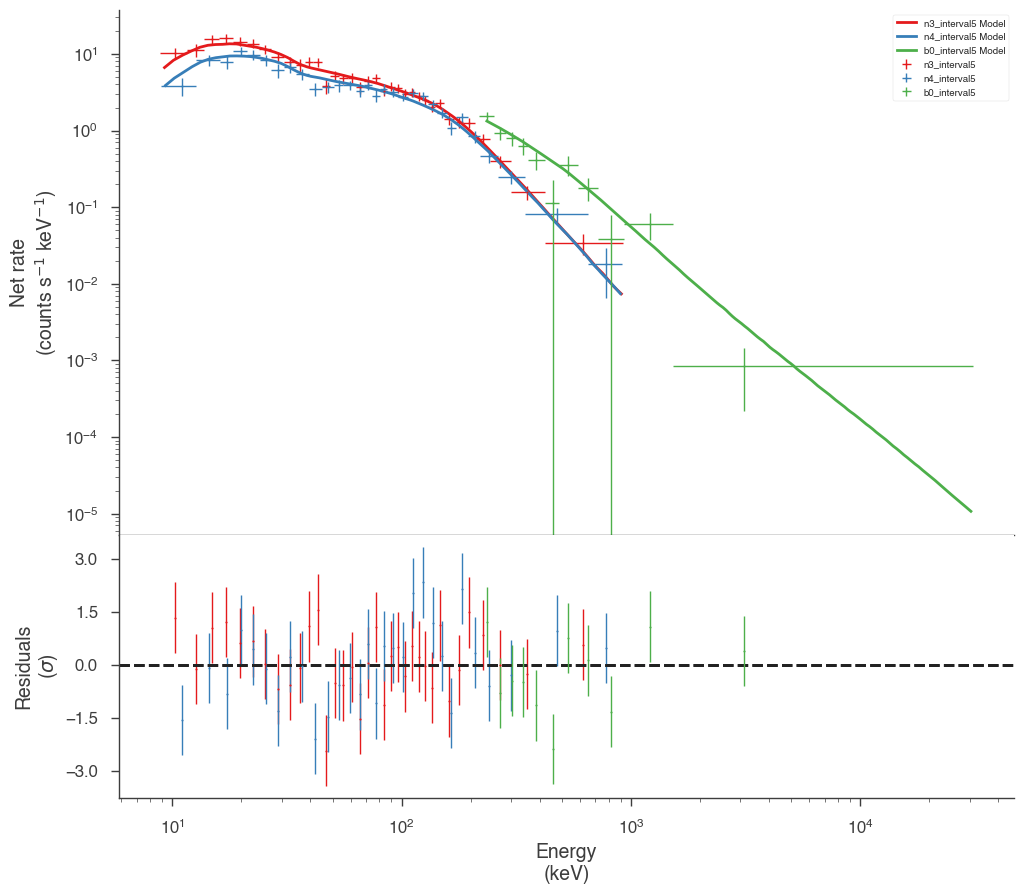

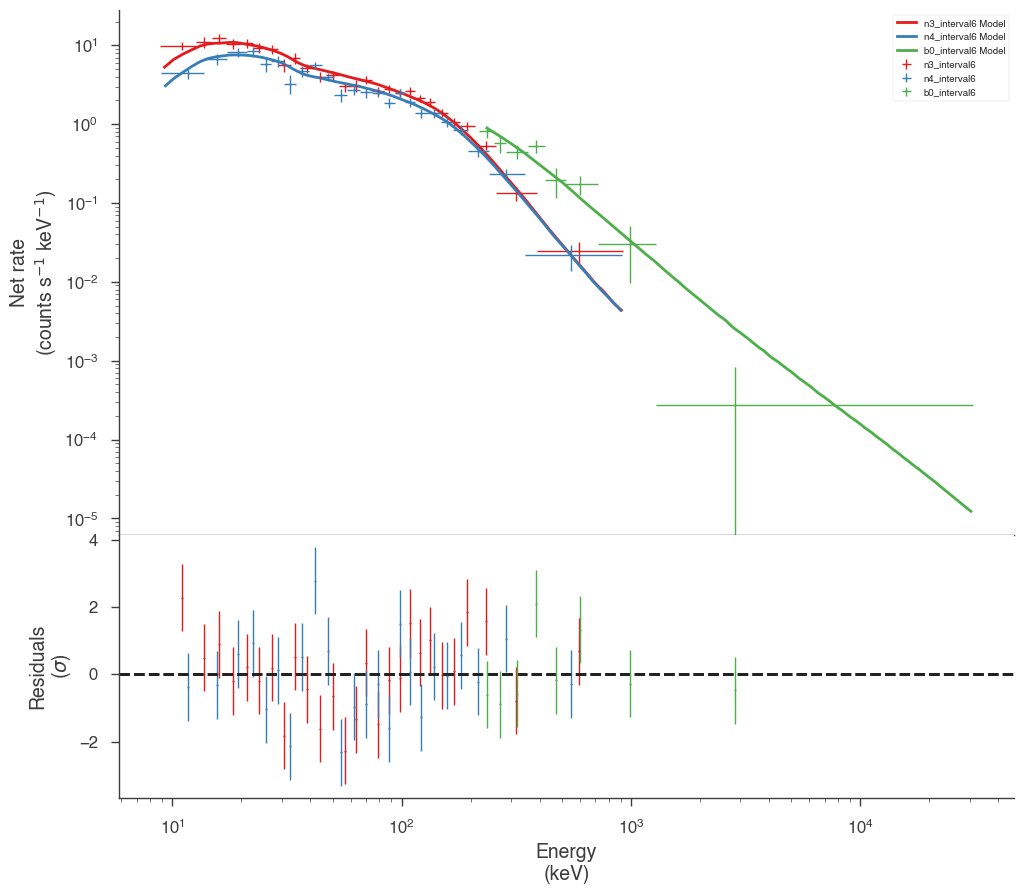

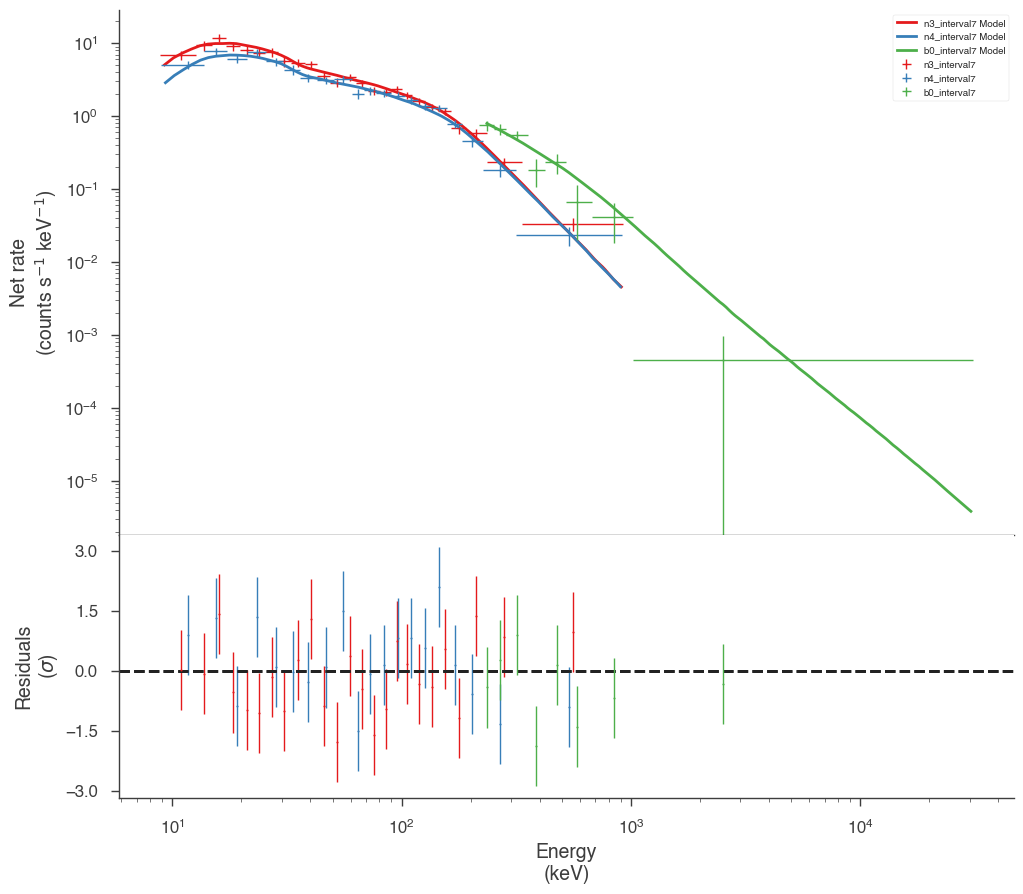

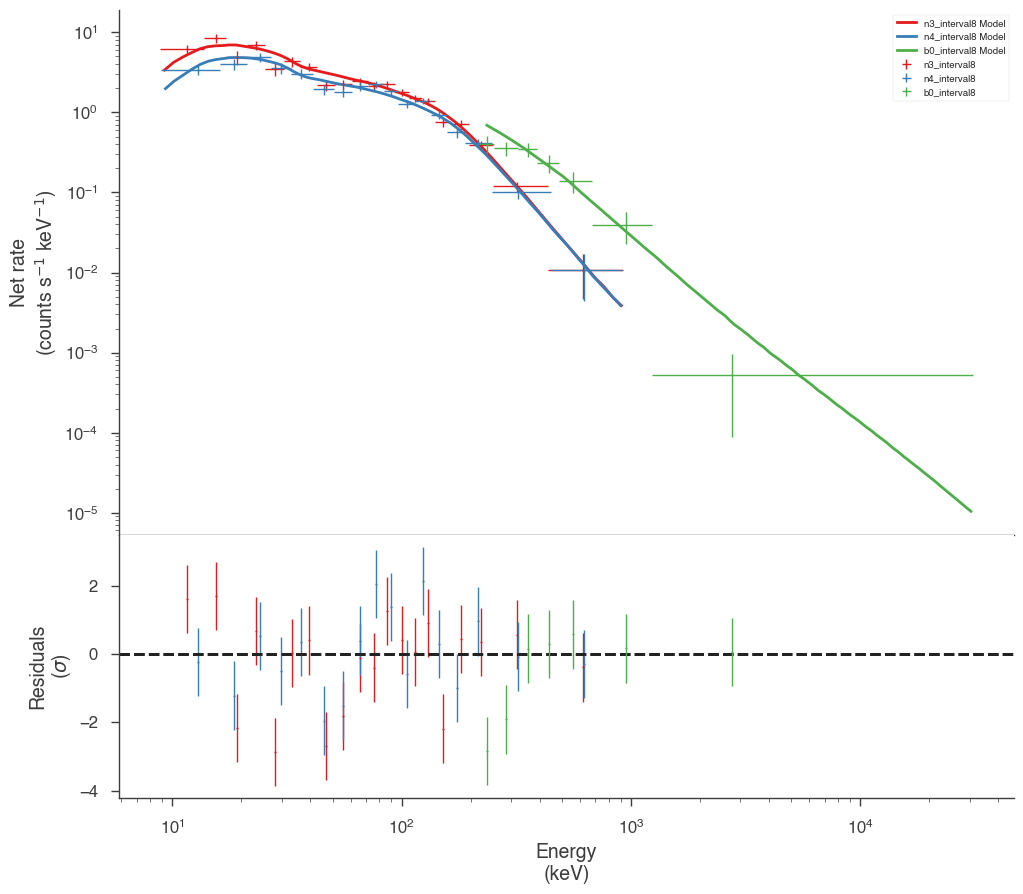

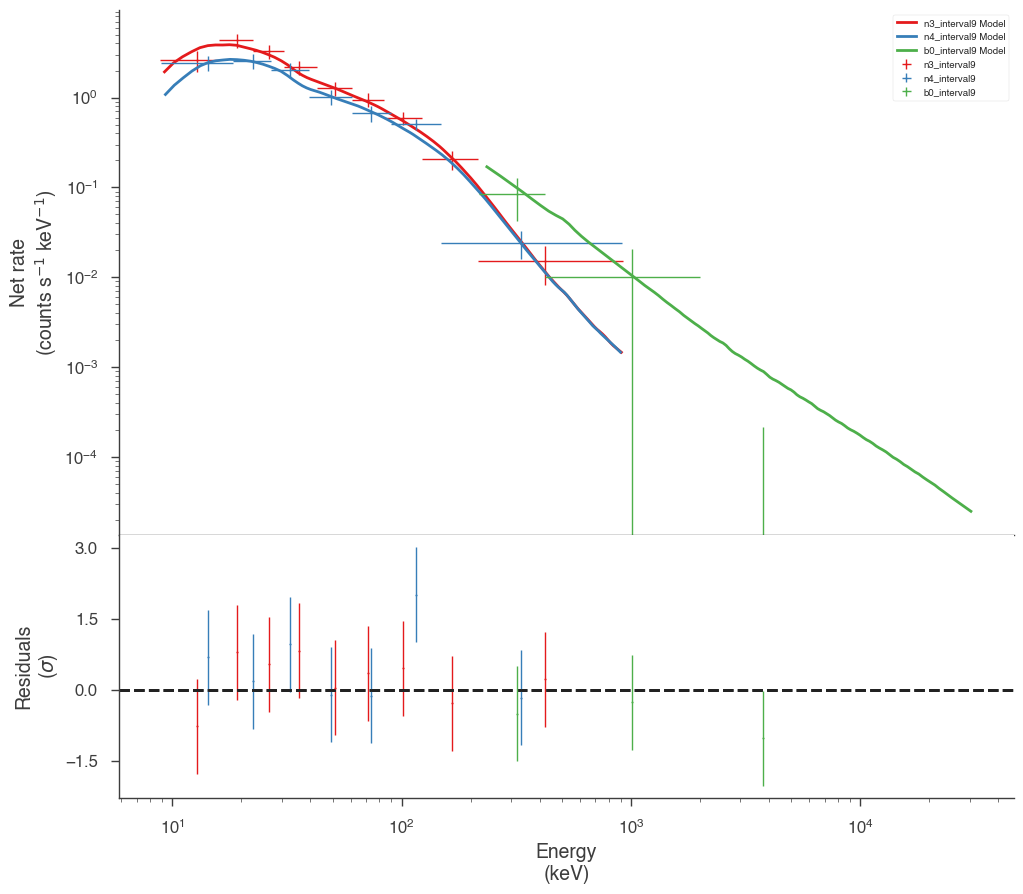

In [24]:
for a in analysis:
    a.restore_median_fit()
    _ = display_spectrum_model_counts(a, min_rate=[20, 20, 20], step=False)

Finally, we can plot the models together to see how the spectra evolve with time.

In [25]:
fig = plot_spectra(
    *[a.results for a in analysis[::1]],
    flux_unit="erg2/(cm2 s keV)",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1),
)

processing Bayesian analyses:   0%|          | 0/12 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

This example can serve as a template for performing analysis on GBM data. However, as 3ML provides an abstract interface and modular building blocks, similar analysis pipelines can be built for any time series data.